In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, CuDNNLSTM, Dropout

# change tensorflow default behavior (where it uses all of the memory at the outset)
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt

import pandas as pd
# plot pandas dates
from pandas.tseries import converter
pd.plotting.register_matplotlib_converters()

# interactive graphs on jupyter notebook
import mpld3

# 1. Data Extraction

In [2]:
filename = '../resources/data/4D_result_2018-01-01_2018-12-31.csv'
raw_data = pd.read_csv(filename, sep=';', dtype={'number': str})
# raw_data.info()

# 2. Data Transformation

In [3]:
transform_data = raw_data.copy()
transform_data.loc[transform_data['company_code'] == 'DMC', 'company_code'] = 'Da Ma Cai'
transform_data.loc[transform_data['company_code'] == 'MAG', 'company_code'] = 'Magnum'
transform_data.loc[transform_data['company_code'] == 'ST', 'company_code'] = 'Sports Toto'

transform_data.loc[transform_data['category'] == 'FST', 'category'] = '1st'
transform_data.loc[transform_data['category'] == 'SCD', 'category'] = '2nd'
transform_data.loc[transform_data['category'] == 'TRD', 'category'] = '3rd'
transform_data.loc[transform_data['category'] == 'SP', 'category'] = 'Special'
transform_data.loc[transform_data['category'] == 'CONS', 'category'] = 'Consolation'

# 3. Data Filtering

In [4]:
date_from = transform_data.min()['draw_date']
date_to = transform_data.max()['draw_date']

# date_from = '2019-01-01'
# date_to = '2019-07-31'

categories = ['1st', '2nd', '3rd', 'Special', 'Consolation']
price_count = sum(list(map(lambda x:
                           (x == '1st' or x == '2nd' or x == '3rd') and 1 or
                           (x == 'Special' or x == 'Consolation') and 10 or 0, categories
                          )))

company_code = 'Magnum'
data = transform_data[(transform_data['number'] != '----') &
                      (transform_data['company_code'] == company_code) &
                      (transform_data['draw_date'] >= date_from) &
                      (transform_data['draw_date'] <= date_to) &
                      (transform_data['category'].isin(categories))]
data = data.sort_values(by=['draw_date', 'company_code', 'category', 'position'])

# 4. Pre-Processing
### 4.1 Input & Target Preparation

In [5]:
period_arr = []
period_dict = data.groupby('draw_date').groups
for k in period_dict.keys():
    period_arr.append([data.loc[i]['number'] for i in period_dict.get(k)])

In [6]:
max_value = 9999
input_data = []
target_data = []

period_count = 1
for i, arr in enumerate(period_arr): 
    if i == len(period_arr) - period_count:
        break
    
    tmp_arr = []
    for n in range(period_count):
        tmp_arr.append(
            list(filter(lambda x: x[0] == i+n, enumerate(period_arr)))[0][1]
        )
    
    # Data Normalization
    input_data.append(
        [[float(n) / max_value for n in tmp_arr2] for tmp_arr2 in tmp_arr]
    )
    target_data.append(
        [float(n) / max_value for n in period_arr[i + period_count]]
    )

In [7]:
input_data = np.array(input_data, dtype=float)
target_data = np.array(target_data, dtype=float)

print('input_data.shape\t', input_data.shape)
print('target_data.shape\t', target_data.shape)

input_data.shape	 (180, 1, 23)
target_data.shape	 (180, 23)


### 4.2 Train & Test Preparation

In [8]:
x_train, x_test, y_train, y_test = train_test_split(input_data, target_data, test_size=0.2, random_state=4)

print('x_train.shape', x_train.shape)
print('x_test.shape', x_test.shape)

# print('x_train:')
# print(x_train[:3])
# print('y_train:')
# print(y_train[:3])
# print()

# start_index = list(filter(lambda x: x[1][0] == '2644', enumerate(period_arr)))[0][0]
# print('input:')
# for n in range(period_count):
#     print(period_arr[start_index + n])
    
# print('target:')
# print(period_arr[start_index + period_count])

x_train.shape (144, 1, 23)
x_test.shape (36, 1, 23)


# 5. Neural Network
### 5.1 Model Definition

In [9]:
model = Sequential()
# model.add(CuDNNLSTM(units=128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(LSTM(units=128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

# model.add(CuDNNLSTM(units=128, return_sequences=True))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))

# model.add(CuDNNLSTM(units=128))
model.add(LSTM(units=128))
model.add(Dropout(0.2))

model.add(Dense(units=price_count))

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['accuracy'])

model.summary()

W0818 23:20:12.101309  5940 deprecation.py:506] From C:\Users\WuQing\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            77824     
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 128)            131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 23)                2

### 5.2 Train Model

In [10]:
start_time = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")
history = model.fit(x_train, y_train, epochs=200, validation_data=(x_test, y_test))
end_time = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")

Train on 144 samples, validate on 36 samples


W0818 23:20:13.583394  5940 deprecation.py:323] From C:\Users\WuQing\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/200
144/144 [==============================] - 7s 49ms/sample - loss: 0.4944 - acc: 0.0417 - val_loss: 0.4801 - val_acc: 0.0556
Epoch 2/200
144/144 [==============================] - 0s 1ms/sample - loss: 0.4765 - acc: 0.0347 - val_loss: 0.4534 - val_acc: 0.0556
Epoch 3/200
144/144 [==============================] - 0s 1ms/sample - loss: 0.4431 - acc: 0.0417 - val_loss: 0.4001 - val_acc: 0.0556
Epoch 4/200
144/144 [==============================] - 0s 979us/sample - loss: 0.3783 - acc: 0.0417 - val_loss: 0.3130 - val_acc: 0.0556
Epoch 5/200
144/144 [==============================] - 0s 993us/sample - loss: 0.2945 - acc: 0.0417 - val_loss: 0.2630 - val_acc: 0.0556
Epoch 6/200
144/144 [==============================] - 0s 1ms/sample - loss: 0.2822 - acc: 0.0694 - val_loss: 0.2681 - val_acc: 0.0556
Epoch 7/200
144/144 [==============================] - 0s 1ms/sample - loss: 0.2675 - acc: 0.0486 - val_loss: 0.2496 - val_acc: 0.1111
Epoch 8/200
144/144 [=============================

144/144 [==============================] - 0s 3ms/sample - loss: 0.2529 - acc: 0.0486 - val_loss: 0.2493 - val_acc: 0.1111
Epoch 62/200
144/144 [==============================] - 0s 3ms/sample - loss: 0.2532 - acc: 0.0208 - val_loss: 0.2488 - val_acc: 0.1111
Epoch 63/200
144/144 [==============================] - 1s 5ms/sample - loss: 0.2530 - acc: 0.0208 - val_loss: 0.2488 - val_acc: 0.1111
Epoch 64/200
144/144 [==============================] - 0s 3ms/sample - loss: 0.2532 - acc: 0.0625 - val_loss: 0.2490 - val_acc: 0.1111
Epoch 65/200
144/144 [==============================] - 0s 3ms/sample - loss: 0.2525 - acc: 0.0208 - val_loss: 0.2492 - val_acc: 0.1111
Epoch 66/200
144/144 [==============================] - 0s 3ms/sample - loss: 0.2525 - acc: 0.0417 - val_loss: 0.2494 - val_acc: 0.1111
Epoch 67/200
144/144 [==============================] - 1s 4ms/sample - loss: 0.2533 - acc: 0.0625 - val_loss: 0.2494 - val_acc: 0.1111
Epoch 68/200
144/144 [==============================] - 0s 3m

Epoch 121/200
144/144 [==============================] - 0s 2ms/sample - loss: 0.2435 - acc: 0.0972 - val_loss: 0.2536 - val_acc: 0.1389
Epoch 122/200
144/144 [==============================] - 0s 1ms/sample - loss: 0.2424 - acc: 0.0556 - val_loss: 0.2537 - val_acc: 0.1389
Epoch 123/200
144/144 [==============================] - 0s 1ms/sample - loss: 0.2428 - acc: 0.1042 - val_loss: 0.2542 - val_acc: 0.1667
Epoch 124/200
144/144 [==============================] - 0s 1ms/sample - loss: 0.2446 - acc: 0.0556 - val_loss: 0.2537 - val_acc: 0.1111
Epoch 125/200
144/144 [==============================] - 0s 1ms/sample - loss: 0.2414 - acc: 0.0764 - val_loss: 0.2541 - val_acc: 0.1111
Epoch 126/200
144/144 [==============================] - 0s 1ms/sample - loss: 0.2419 - acc: 0.0625 - val_loss: 0.2537 - val_acc: 0.1111
Epoch 127/200
144/144 [==============================] - 0s 1ms/sample - loss: 0.2416 - acc: 0.0764 - val_loss: 0.2528 - val_acc: 0.1667
Epoch 128/200
144/144 [==================

Epoch 181/200
144/144 [==============================] - 0s 979us/sample - loss: 0.2332 - acc: 0.1042 - val_loss: 0.2580 - val_acc: 0.0000e+00
Epoch 182/200
144/144 [==============================] - 0s 896us/sample - loss: 0.2324 - acc: 0.1111 - val_loss: 0.2567 - val_acc: 0.0278
Epoch 183/200
144/144 [==============================] - 0s 896us/sample - loss: 0.2344 - acc: 0.1389 - val_loss: 0.2562 - val_acc: 0.0278
Epoch 184/200
144/144 [==============================] - 0s 910us/sample - loss: 0.2337 - acc: 0.1111 - val_loss: 0.2561 - val_acc: 0.0278
Epoch 185/200
144/144 [==============================] - 0s 924us/sample - loss: 0.2327 - acc: 0.1181 - val_loss: 0.2572 - val_acc: 0.0278
Epoch 186/200
144/144 [==============================] - 0s 875us/sample - loss: 0.2331 - acc: 0.1181 - val_loss: 0.2567 - val_acc: 0.0000e+00
Epoch 187/200
144/144 [==============================] - 0s 951us/sample - loss: 0.2336 - acc: 0.1181 - val_loss: 0.2568 - val_acc: 0.0000e+00
Epoch 188/200
1

### 5.3 Result Prediction

In [11]:
print(f'Train Start:\t{start_time}')
print(f'Train End:\t{end_time}')

results = model.predict(x_test)

print('results.shape', results.shape)
print('y_test.shape', y_test.shape)

Train Start:	2019-08-18 23:20:13.258375
Train End:	2019-08-18 23:21:07.660487
results.shape (36, 23)
y_test.shape (36, 23)


# 6. Result Visualization

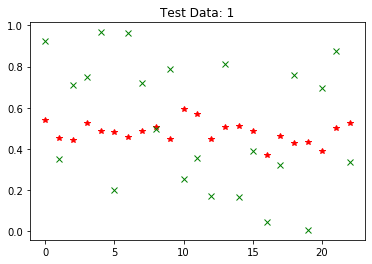

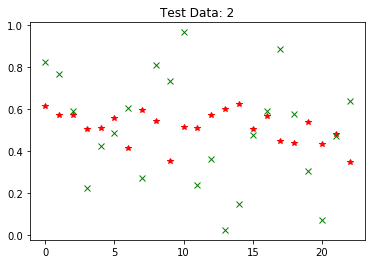

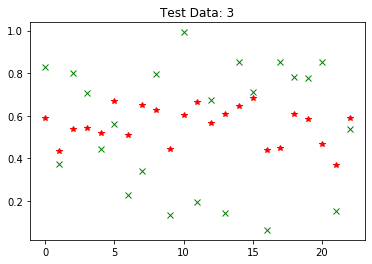

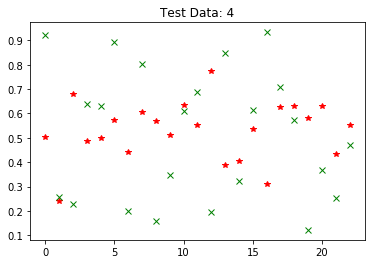

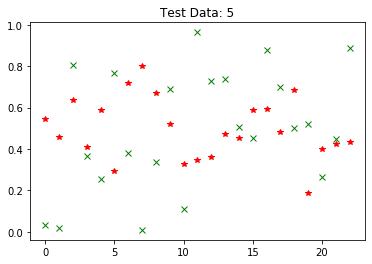

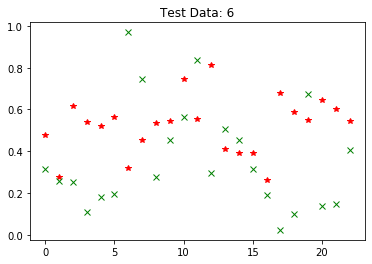

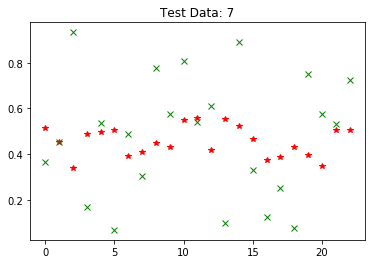

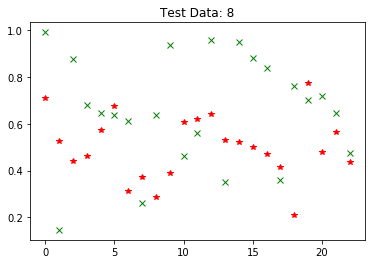

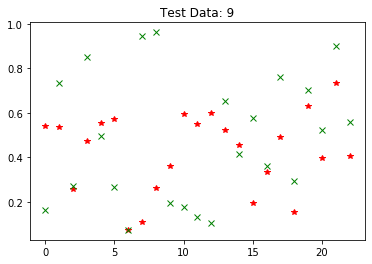

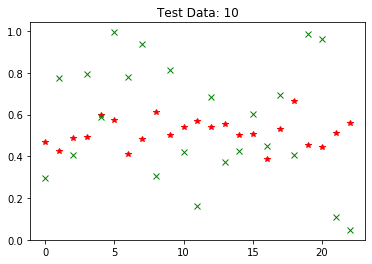

In [12]:
mpld3.enable_notebook()
plt.rcParams['figure.figsize'] = [6, 4]

for i, arr in enumerate(y_test[:10]):
    plt.title(f'Test Data: {i+1}')
    plt.plot(range(results.shape[1]), results[i], c='r', marker='*', ls='none')
    plt.plot(range(results.shape[1]), arr, c='g', marker='x', ls='none')
    plt.show()

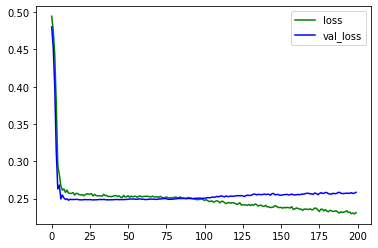

In [13]:
plt.plot(history.history['loss'], c='g', label='loss')
plt.plot(history.history['val_loss'], c='b', label='val_loss')
plt.legend()
plt.show()